In [176]:
using GeoStats, GeoStatsFunctions, Distances
using GeoStatsFunctions: fit
using GLMakie, MakieLayers
using SpatRasters
import SpatRasters: st_dims

SK = GeoStatsModels.SimpleKriging
OK = GeoStatsModels.OrdinaryKriging
UK = GeoStatsModels.UniversalKriging
DK = GeoStatsModels.UniversalKriging

sf_point(x, y) = Meshes.Point(LatLon(y, x)) # note `lat` at first

function st_dims(domain::RegularGrid)
  p0 = domain.origin.coords
  y0, x0 = p0.lat.val, p0.lon.val
  
  ny, nx = size(domain.topology)
  celly, cellx = domain.spacing
  celly = celly.val
  cellx = cellx.val
  
  lon = x0+cellx/2:cellx:x0+cellx*nx #|> collect
  lat = y0+celly/2:celly:y0+celly*ny #|> collect
  lon, lat#[end:-1:1]
end


st_dims (generic function with 4 methods)

In [149]:
b = bbox(108.5, 31.5, 112 - 0.5, 33.5)
cellsize = 0.02
domain = RegularGrid(sf_point(b.xmin, b.ymin), sf_point(b.xmax, b.ymax), (1, 1) .* cellsize)
p = centroid(domain, 1)

Point with GeodeticLatLon{WGS84Latest} coordinates
├─ lat: 31.509999999999998°
└─ lon: 108.50999999999999°

In [2]:
using RTableTools
d = fread("./prcp_st174_shiyan.csv")
data = georef(d[:, [1, 2, 4]], (:lon, :lat))  # 指定坐标列

prcp,geometry
Continuous,Point
[NoUnits],🖈 GeodeticLatLon{WGS84Latest}
0.5,"(lat: 31.617°, lon: 109.767°)"
0.0,"(lat: 32.233°, lon: 109.9°)"
0.0,"(lat: 32.271°, lon: 109.901°)"
0.0,"(lat: 31.983°, lon: 109.917°)"
0.0,"(lat: 32.017°, lon: 109.833°)"
0.0,"(lat: 31.967°, lon: 109.85°)"
0.0,"(lat: 31.99°, lon: 109.783°)"
0.0,"(lat: 31.883°, lon: 109.817°)"


In [150]:
var = :prcp
γ_emp = EmpiricalVariogram(data, var, maxlag=200_000.0)
γ = GeoStatsFunctions.fit(GaussianVariogram, γ_emp) # `maxlag` in the unit of m
ok = GeoStatsModels.fit(OK(γ), data)

# i = 1
p = centroid(domain, i)
r = GeoStatsModels.predictprob(ok, :prcp, p) #with μ, σ
r

Distributions.Normal{Float64}(μ=2.362604735060514, σ=20.36543610802627)

In [179]:
point = true
prob = false
@time r = GeoStatsModels.fitpredict(ok.model, data, domain; point, prob, neighbors=false, distance=Haversine())
r
# ra = georef(r, domain)

LoadError: ArgumentError: the latitude must be in the range [-90°,90°], while 90.0000000038745° was provided

In [153]:
point = true
prob = false
@time r = GeoStatsModels.fitpredictfull(ok.model, data, domain, point, prob)
ra = georef(r, domain)

  0.646450 seconds (240.10 k allocations: 28.948 MiB, 0.70% gc time)


prcp,geometry
Continuous,Quadrangle
[NoUnits],🖈 GeodeticLatLon{WGS84Latest}
2.3626,"Quadrangle((lat: 31.5°, lon: 108.5°), ..., (lat: 31.5°, lon: 108.52°))"
2.4226,"Quadrangle((lat: 31.52°, lon: 108.5°), ..., (lat: 31.52°, lon: 108.52°))"
2.48619,"Quadrangle((lat: 31.54°, lon: 108.5°), ..., (lat: 31.54°, lon: 108.52°))"
2.55318,"Quadrangle((lat: 31.56°, lon: 108.5°), ..., (lat: 31.56°, lon: 108.52°))"
2.6233,"Quadrangle((lat: 31.58°, lon: 108.5°), ..., (lat: 31.58°, lon: 108.52°))"
2.6963,"Quadrangle((lat: 31.6°, lon: 108.5°), ..., (lat: 31.6°, lon: 108.52°))"
2.77191,"Quadrangle((lat: 31.62°, lon: 108.5°), ..., (lat: 31.62°, lon: 108.52°))"
2.84982,"Quadrangle((lat: 31.64°, lon: 108.5°), ..., (lat: 31.64°, lon: 108.52°))"


In [85]:
domain.topology

20×30 GridTopology(aperiodic, aperiodic)

In [154]:

lon, lat = st_dims(domain)

(108.51:0.02:111.49, 31.51:0.02:33.49)

In [155]:
A = reshape(ra.prcp, size(domain))' |> collect

150×100 Matrix{Float64}:
 2.3626   2.4226   2.48619  2.55318  …   0.441711    0.484976    0.532995
 2.2642   2.32643  2.39236  2.46177      0.306802    0.352198    0.402447
 2.16436  2.22886  2.29717  2.36904      0.172252    0.219843    0.272383
 2.06316  2.12998  2.2007   2.27507      0.0383474   0.088197    0.143088
 1.9607   2.02987  2.10305  2.17996     -0.0946149  -0.0424439   0.0148572
 1.85707  1.92864  2.0043   2.08378  …  -0.226325   -0.17177    -0.112002
 1.75238  1.82638  1.90456  1.98665     -0.356459   -0.299461   -0.237171
 1.64675  1.7232   1.80394  1.88866     -0.484684   -0.425183   -0.360317
 1.54028  1.61923  1.70254  1.78992     -0.610654   -0.548593   -0.481098
 1.43311  1.51457  1.60049  1.69055     -0.734011   -0.669334   -0.599163
 1.32536  1.40936  1.49791  1.59067  …  -0.854387   -0.787041   -0.714147
 1.21716  1.30373  1.39492  1.49041     -0.971405   -0.901339   -0.825679
 1.10867  1.19781  1.29167  1.38988     -1.08468    -1.01184    -0.933377
 ⋮          

In [157]:
size(A), length(lon), length(lat)

((150, 100), 150, 100)

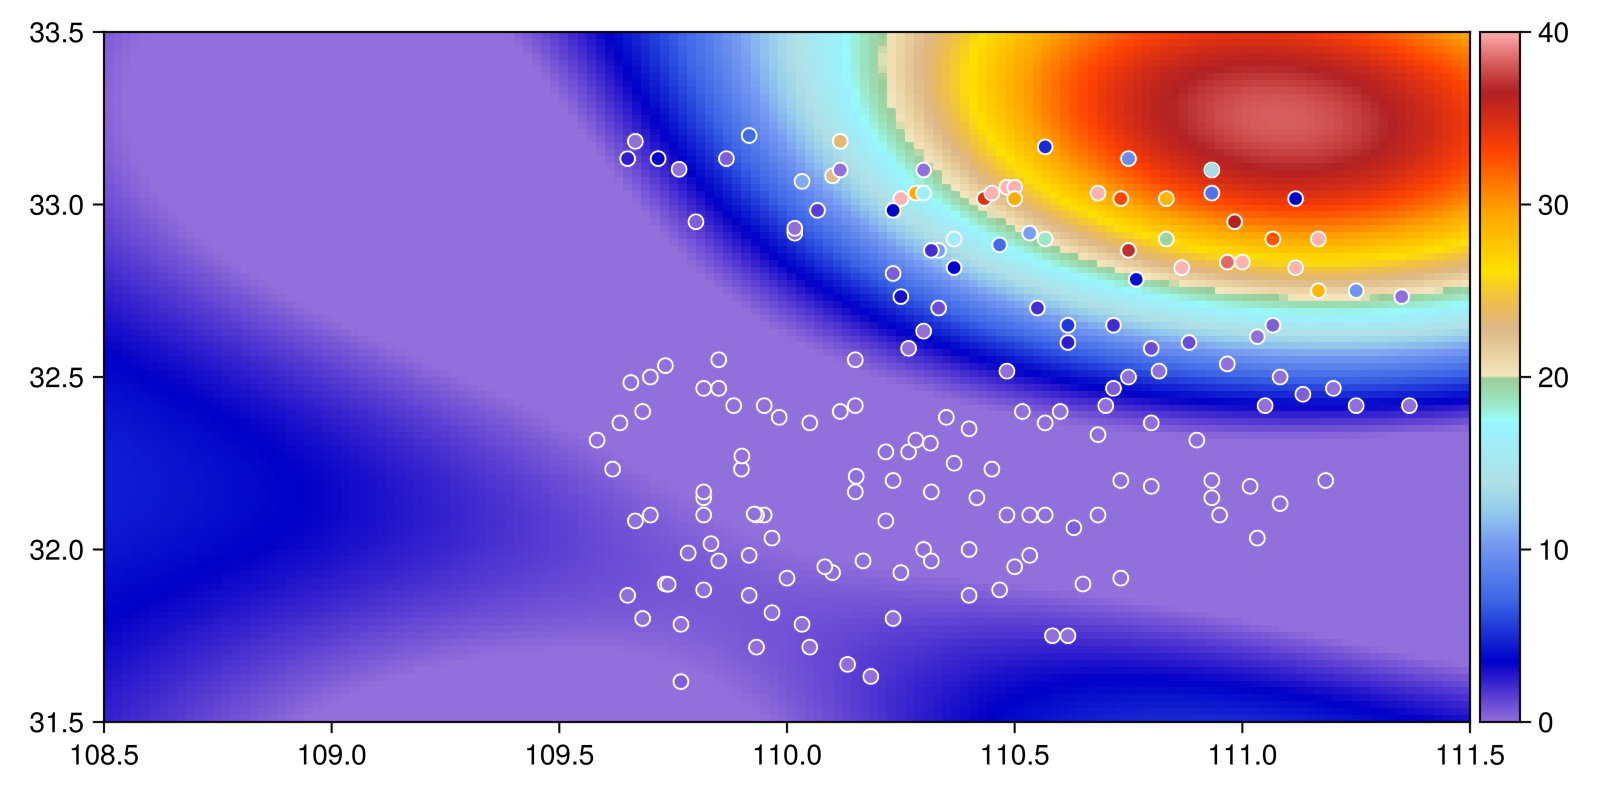

In [173]:
colors = amwg256
colorrange=(0, 40)

fig = Figure(; size=(800, 400))
# ax = Axis(fig[1, 1])
ax, plt = imagesc!(fig[1, 1], lon, lat, A; colors, colorrange, force_show_legend=true)
scatter!(ax, d.lon, d.lat; color=d.prcp, strokecolor=:white, strokewidth=1, colormap=colors, colorrange)
fig

In [73]:
# Matrix(ra) ## how to convert into matrix

In [34]:
γ = GaussianVariogram(range=200_000, sill = 420, nugget=80)
ok = GeoStatsModels.fit(OK(γ), data)
ok.model

GeoStatsModels.OrdinaryKriging{GaussianVariogram{MetricBall{1, Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}}, LinearAlgebra.UniformScaling{Bool}, Euclidean}, Float64}}(GaussianVariogram(range: 200000.0 m, sill: 420.0, nugget: 80.0))

In [41]:
i = 1
p = centroid(domain, i)
r = GeoStatsModels.predictprob(ok, :prcp, p) #with μ, σ
r
# R[i, 2] = r.μ, r.

Distributions.Normal{Float64}(μ=-0.9235024404589074, σ=10.787546986407339)

In [45]:
methods(GeoStatsModels.predict)

# 9 methods for generic function "predict" from GeoStatsModels:
 [1] predict(fitted::GeoStatsModels.FittedNN, var::Symbol, gₒ)
     @ C:\Users\hydro\.julia\packages\GeoStatsModels\8pAaD\src\nn.jl:43
 [2] predict(fitted::GeoStatsModels.FittedKriging, var::Symbol, gₒ)
     @ C:\Users\hydro\.julia\packages\GeoStatsModels\8pAaD\src\krig.jl:216
 [3] predict(fitted::GeoStatsModels.FittedKriging, var::AbstractString, gₒ)
     @ C:\Users\hydro\.julia\packages\GeoStatsModels\8pAaD\src\krig.jl:214
 [4] predict(model::GeoStatsModels.FittedGeoStatsModel, var::AbstractString, gₒ)
     @ C:\Users\hydro\.julia\packages\GeoStatsModels\8pAaD\src\models.jl:54
 [5] predict(fitted::GeoStatsModels.FittedKriging, vars, gₒ)
     @ C:\Users\hydro\.julia\packages\GeoStatsModels\8pAaD\src\krig.jl:218
 [6] predict(fitted::GeoStatsModels.FittedLWR, var::Symbol, gₒ)
     @ C:\Users\hydro\.julia\packages\GeoStatsModels\8pAaD\src\lwr.jl:82
 [7] predict(fitted::GeoStatsModels.FittedPolynomial, var::Symbol, gₒ)
     @ C:\Users\hydro\.julia\packages\GeoStatsModels\8pAaD\src\poly.jl:85
 [8] predict(fitted::GeoStatsModels.FittedIDW, var::Symbol, gₒ)
     @ C:\Users\hydro\.julia\packages\GeoStatsModels\8pAaD\src\idw.jl:55
 [9] predict(model::GeoStatsModels.FittedGeoStatsModel, vars, gₒ)
     @ C:\Users\hydro\.julia\packages\GeoStatsModels\8pAaD\src\models.jl:55

In [43]:
r = GeoStatsModels.predict(ok, :prcp, p) # with no probability

33.5137579116751

In [42]:
## 
N = nelements(domain)
R = zeros(N, 2)
for i in 1:N
  p = centroid(domain, i)
  r = GeoStatsModels.predictprob(ok, :prcp, p)
  R[i, :] .= r.μ, r.σ
end
R

400×2 Matrix{Float64}:
 -0.923502  10.7875
 -0.165615  10.2511
  0.498564   9.89383
  0.984645   9.67498
  1.23116    9.54959
  1.20954    9.48168
  0.929296   9.45049
  0.437462   9.44908
 -0.188087   9.4777
 -0.85018    9.53556
 -1.44693    9.61477
 -1.88676    9.69943
 -2.1013     9.77105
  ⋮         
  0.500119  10.0713
  4.45081    9.94795
  9.23443    9.8951
 14.5315     9.90681
 19.9507     9.98808
 25.0724    10.1552
 29.4977    10.433
 32.8947    10.8489
 35.0346    11.4242
 35.8142    12.1656
 35.2594    13.0603
 33.5138    14.0772

In [48]:
γ_emp = EmpiricalVariogram(data, :prcp, maxlag=200_000.0)
γ = GeoStatsFunctions.fit(GaussianVariogram, γ_emp) # `maxlag` in the unit of m

EmpiricalVariogram
├─ abscissas: [6911.68 m, 15723.7 m, 25252.8 m, ..., 1.74484e5 m, 1.84076e5 m, 1.93314e5 m]
├─ ordinates: [60.5316, 103.26, 127.329, ..., 306.184, 517.715, 482.896]
├─ distance: Euclidean(0.0)
├─ estimator: MatheronEstimator()
└─ npairs: 15050

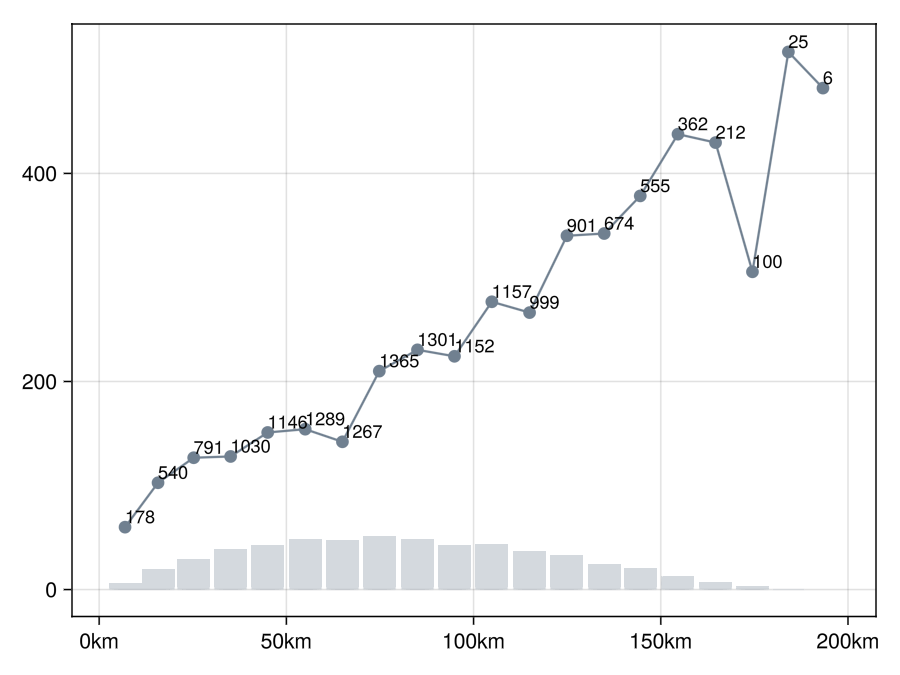

In [49]:
funplot(γ_emp)

In [50]:
γ = GeoStatsFunctions.fit(GaussianVariogram, γ_emp) # `maxlag` in the unit of m
# x = 0.01:1_000:200_000
# plot(x, γ.(x))

GaussianVariogram
├─ range: 1.93314e5 m
├─ sill: 418.157
└─ nugget: 84.3846

In [160]:
model = Kriging(γ)
R = data |> Interpolate(domain; model)
# domain

LoadError: ArgumentError: the latitude must be in the range [-90°,90°], while 90.0000000038745° was provided